   
   
# Assignment 3

### Setting up Colab Research environment (Optional)

In [ ]:
#@title
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/HW3")

### Imports

In [ ]:
import pandas as pd
import numpy as np
import scipy
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smgraphics
from scipy import stats
from scipy.stats import skew

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')



## **Problem 4: Linear regresion analysis**

### **1. Have a closer look at the definitions of the variables and analyze which of them might require a separate treatment. Consider for example the variable $ed$. There are two possibilities how the variable ed can be included into the model (one with dummy variables, the other one without dummies). Think about these two approaches and suggest which approach is more appropriate. Motivate your decision.**

Importing dataset:

In [ ]:
df = pd.read_csv('telco.txt', sep='\t')

Let's see how dataset looks like:

In [ ]:
df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


Generally we can use following approaches to encode categorical variables:
- assume that there is no established order between values in category and apply DUMMY variable approach: binary (if there are only two values in category) or one-hot encoding (more that two values in category);
- assume that there an established order between values and treating category as ordinal, encoding each value in some decreasing or increasing order, which give us certain order. Here we can also apply so called impact (target) encoding techniques, established in various data science contests as vary useful for certain type of predictive algorithms.
- assume that there is only difference between two or more clusters of categorical values, like 'have an education' and "no education", encoding all values respectively.

Before considering **"ed"** variable we will take of other categoricals, as we are already instructed how to encode them in Assignment. Varibles "marital","retire","gender" and "churn" have no natural order between them. They must contain only two values per each. Let's check it (whether there is some data cleaning need):

In [ ]:
binary_cols = df.select_dtypes(include=['category','object']).drop('ed',axis=1).columns.tolist()
for col in binary_cols:
    print("values in",col,":",df[col].unique().tolist())
    print('len:',len(df[col].unique().tolist()))
    print('')

values in marital : ['Married', 'Unmarried']
len: 2

values in retire : ['No', 'Yes']
len: 2

values in gender : ['Male', 'Female']
len: 2

values in churn : ['Yes', 'No']
len: 2



As we supposed, we have two value per categories "marital","retire","gender" and "churn". 

Now let's look closer at variable "ed". What possible values does our dataset have under category "ed" ?

In [ ]:
df.ed.unique().tolist()

['College degree',
 'Post-undergraduate degree',
 'Did not complete high school',
 'High school degree',
 'Some college']

Variable ed contains 5 possible values, each of which corresponds to certain level of education. Each of these values must be encoded. Let's consider this issue in the context of whether they shall be dummy-encoded or not:

**Considerations:**
- Generally, there is no silver bullet in this case as we don't know beforehand whether there is actually some linear dependence between level of education and $longmon$;
- It is surely possible that $longmon$ can be both negatively and positively affected by level of education as in some cases level of education prevents people from using 'scam-products', but in other cases level of education can be interacted with income variable in some non-linear way,like $ed^2 income$,signalling readiness to use a product for a long time etc.;
- We can do dummy variable (one-hot) encoding and hope that during linear regression we will capture with our coefficients relative dependence between every categorical value and $longmon$. This will definitely be more plausible than assumption that we have an eastablished magnitutes of differences between each value like 'Did not complete high school' = 0, 'High school degree' = 1, 'Some college' : 2....etc.;  
- It can also be the case that there is no difference between levels of education, but only between having any education and no education at all. In this case we can do simple binary encoding;
- In any case, during statistical analysis (performed in a loop 'feature engineering'-'feature selection'-'modelling'-'interpretation') we must at least compare few encoding approaches with regards to regression results such as Adjusted-R and statistical significance of coefficients. There could a trade-off between accuracy and interpetability in our choices.

**Decision:** 

For the first regression run I will use dummy encoding.

**Reasons:**

- I don't know whether and to what degree there is a difference between levels of education in its influence on churn rate. 
- Dummy encoding can capture more possible magnitudes of differences between 'College degree','Post-undergraduate degree', 'Did not complete high school', High school degree', 'Some college' then just 'Did not complete high school' = 0, 'High school degree' = 1, 'Some college' : 2....etc.
- We have only 5 distinct values and won't increse dimensionality of our dataset too much.

Exctracting interval scaled variables before encoding categoricals:

In [ ]:
interval_vars = df.select_dtypes(include=['float','int']).columns.tolist()

Let's now perform encoding to all categoricals:

In [ ]:
df['marital'] = df['marital'].apply(lambda val: 1 if val == 'Married' else 0)
df['retire'] = df['retire'].apply(lambda val: 1 if val == 'Yes' else 0)
df['gender'] = df['gender'].apply(lambda val: 1 if val == 'Male' else 0)
df['churn'] = df['churn'].apply(lambda val: 1 if val == 'Yes' else 0)

One-hot to "ed":

In [ ]:
df = pd.get_dummies(df,drop_first=True)

### **2. Consider now the dependent variable and the interval (metric) scaled explanatory variables. Plot these data and decide if you wish to transform these $x-variables$ and if there is a need to transform the $y-variable$. You can also use some measure of skewness to decide about $y$. The variable $wiremon$ shows a very specific pattern. How would you take it into account?**

Generally, nor dependent neither independent variables are required to be normally distributed $per$ $se$ in linear regression. The requirement is about normal distribution of residuals. However, frequently, log transformation of independent variable can help in getting normal residuals. On this stage we can also explore independent variables on whether we can do some feature engineering based on their distribution.

Also we know that one of the requirements for model (coefficients,p-values) interpretation and specification is that there is no strong multicollinearity between independent variables. 
Let's firstly check simple pairwise collinearity with correlation matrix and condition number as in case of collinearity we may want to log transform or delete our independent variables.

Plotting correlation matrix:

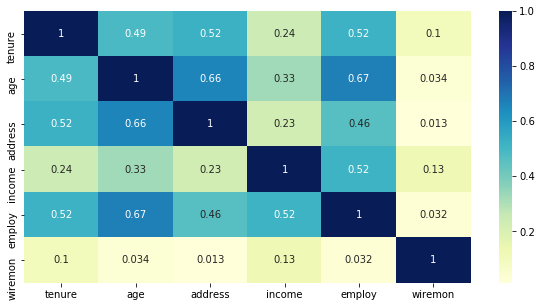

In [ ]:
#let's plot correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df[interval_vars].drop('longmon',axis=1).corr(),cmap="YlGnBu",annot=True)
plt.show()

Condition number as one of indicators of overall multicollinarity in generalized linear models. Let's check whether condition number is higher than 30, as it will signal on some severe multicollinearilty. This rule of thumb is from "Belsley, David (1991). Conditioning Diagnostics: Collinearity and Weak Data in Regression".

In [ ]:
print(np.linalg.cond(df[interval_vars].drop('longmon',axis=1).corr()))

12.41773850885095


**Conclusion:** There is no overall severe multicollinarity in our basic feature set as cond.number < 30.

Let's now look at distribution of dependent and independent variables.

#### Dependent variable 'longmon'

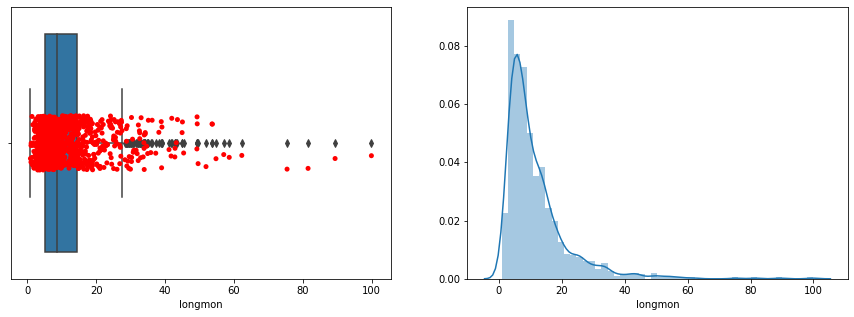

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

lsns.stripplot(df['longmon'], color="red", ax=axes[0])
sns.distplot(df['longmon'], ax=axes[1])
plt.show()

It is already obvious that data is skewed, but we will also use skewness measure as adjusted Fisher-Pearson standardized moment coefficient formula:

$G_1 = \frac{\sqrt{N(N-1)}}{N-2} \frac{m_3}{m_2^{3/2}}$

,where

- $m_i = \frac{1}{N}\sum_{n=1}^{N}(x[n]-\bar{x})^i$ - $i$th sample central moment; 

- $\bar{x}$ - the sample mean;

- $\frac{\sqrt{N(N-1)}}{N-2}$ - correction for sample bias.

As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed:

In [ ]:
print(skew(df['longmon'],bias=False))

2.9661041299742346


**Conclusion**: our dependent variable is highly skewed.

We know, that in linear regression there is no assumption regarding normality of dependent variable (only residuals). But it is also widespread practice to make dependent variable more normal as it can help in making out residuals normal. But let's see a plot of natural log of $y-variable$: 

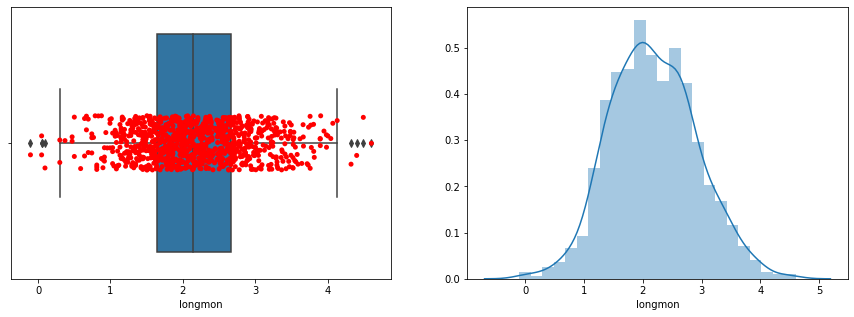

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(np.log(df['longmon']),ax=axes[0])
sns.stripplot(np.log(df['longmon']), color="red", ax=axes[0])
sns.distplot(np.log(df['longmon']), ax=axes[1])
plt.show()

Data became more symmetric around the mean. 

**Decision**:

Given all above-mentioned, I'll transform our dependent variable 'longmon':

In [ ]:
df['longmon_log'] = np.log(df.longmon).values

#### Independent variables

Generally, there is no need to ensure normality of independent variables but let's look as an example at some of them, such as $tenure$ and $wiremon$ for the sake of feature engineering demonstration.

**"tenure"**

Plotting boxplot and pdf to see distributions:

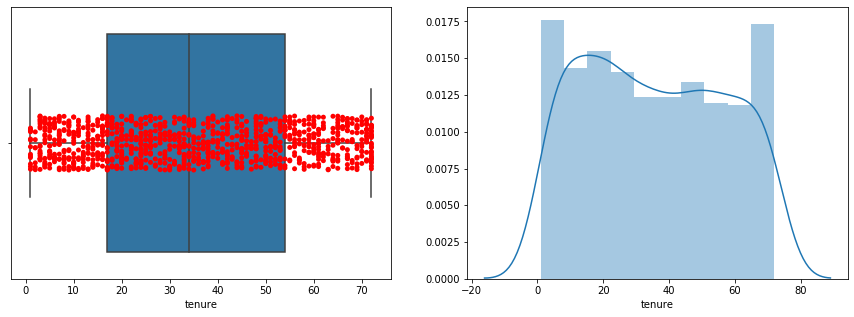

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(df['tenure'],ax=axes[0])
sns.stripplot(df['tenure'], color="red", ax=axes[0])
sns.distplot(df['tenure'], ax=axes[1])
plt.show()

**Conclusion**:

Seems like $tenure$ can have 2 clusters, being bimodal, but tails are not that different from the center, so I won't do anything about this variable or create a new additional variable (indicator).



**"wiremon"**

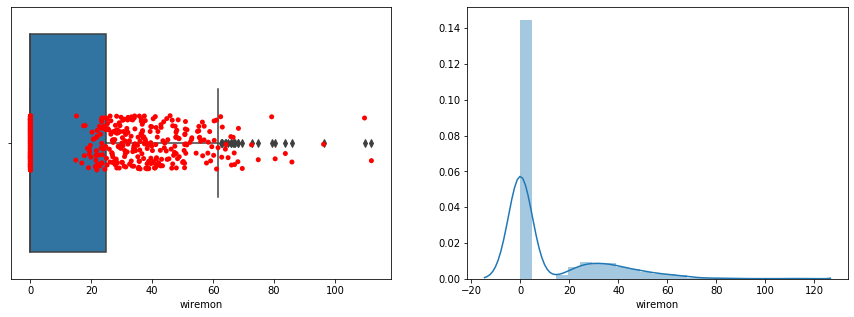

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(df['wiremon'],ax=axes[0])
sns.stripplot(df['wiremon'], color="red", ax=axes[0])
sns.distplot(df['wiremon'], ax=axes[1])
plt.show()

**Conclusion**:

It seem like we need an indicator variable which signals whether a user used an internet last month at all, as a whole bunch of people didn't do that and this fact skews our distribution a lot. Let's create such binary variable in our dataset, where "0" means didn't use Internet, "1" means used and see their distribution:

In [ ]:
df['used_wire'] = 0
df.loc[df.wiremon>0,'used_wire']=1

We will stop dealing with independent variables as in general we don't need their normality (only residuals) and looked at above two for the sake of demonstration of feature engineering.

### **3. After making up your decision about the above two problems run a simple linear regression. Pick up one of the regressors. Write down the corresponding hypothesis of the t-test. Provide the formula for the test statistics, explain the components of the formula and give the values for this components. Evaluate the goodness of the model. Explain in your own words the difference between $R^2$ and adjusted $R^2$.**

Running regression:

In [ ]:
x = df.drop(['longmon_log','longmon'],axis=1).copy()
x = sm.add_constant(x)
y = df['longmon_log'].copy()
model = sm.OLS(y, x)
result = model.fit()
summary = result.summary()


In [ ]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            longmon_log   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     166.4
Date:                Sun, 09 Feb 2020   Prob (F-statistic):          2.72e-257
Time:                        02:43:50   Log-Likelihood:                -478.43
No. Observations:                1000   AIC:                             988.9
Df Residuals:                     984   BIC:                             1067.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.2459      0.064     19.388      0.000       1.120       1.372
tenure                              0.0273      0.001     34.252      0.000       0.026       0.029
age                                -0.0025      0.002     -1.524      0.128      -0.006       0.001
marital                             0.0696      0.026      2.720      0.007       0.019       0.120
address                             0.0038      0.002      2.180      0.030       0.000       0.007
income                           -8.51e-05      0.000     -0.574      0.566      -0.000       0.000
employ                              0.0036      0.002      1.774      0.076      -0.000       0.008
retire                              0.1983      0.069      2.889      0.004       0.064       0.333
gender                              0.0347      0.025      1.382      0.167      -0.015       0.084
wiremon                          1.548e-05      0.002      0.010      0.992      -0.003       0.003
churn                              -0.0387      0.031     -1.255      0.210      -0.099       0.022
ed_Did not complete high school    -0.1329      0.042     -3.189      0.001      -0.215      -0.051
ed_High school degree              -0.0340      0.036     -0.937      0.349      -0.105       0.037
ed_Post-undergraduate degree       -0.1014      0.055     -1.840      0.066      -0.210       0.007
ed_Some college                    -0.0409      0.038     -1.073      0.284      -0.116       0.034
used_wire                          -0.0044      0.066     -0.067      0.947      -0.134       0.126
==============================================================================
Omnibus:                        2.172   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.338   Jarque-Bera (JB):                2.141
Skew:                          -0.050   Prob(JB):                        0.343
Kurtosis:                       3.203   Cond. No.                         875.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis for t-test:

Let's pickup "$ed$_$Did$ $not$ $complete$ $high$ $school$" as a regressor. Let's call coefficient corresponding to it as $\beta$.

Null hypothesis of t-test by default (in scipy and other statistical software) is usually such that there is no relationship between regressor and dependent variable:

$H_0: \beta = 0$

Alternative hypothesis of t-test is that there is either positive or negative relationship between "marital" and "longmon":

$H_1: \beta \not= 0$.

#### Formula for t-test:

Formula:

$t = \frac{\beta - \beta_{H_0}}{\sqrt{Var(\beta)}}$

,where

- $\beta$ - our estimated coefficient;
- $\beta_{H_0}$ - coefficient according to null hypothesis;
- $\sqrt{Var(\beta)}$ - standard error of our estimated coefficient.

### Values for components of formula

From above table we can extract values for the formula:

- $\beta = -0.1329$;
- $\beta_{H_0} = 0$;
- $\sqrt{Var(\beta)} = 0.042$.

Let's compute t-value manually and compare it with computed by OLS procedure in statsmodels:

In [ ]:
-0.1329 / 0.042

-3.1642857142857137

This is appr.equal to t-value, found by statsmodels.

**On Adjusted-$R^2$ vs. $R^2$:**

$R^2$ measures ratio of model explained dependent variable variance to actual dependent variable variance. Adjusted-$R^2$ practically measures the same, but takes into account number of independet variables, imposing penalty for models with lots of 'rubbish' variables that have only overfitting effect on the model.

### **4.Compute manually the predicted values from the above regression and the residuals. Make two plots: residuals vs. predicted y’s and predicted y’s vs. true y’s. What do you expect in both cases and why? Do the obtained figures support your expectations?**

Let's extract all computed $\beta$-coefficients from our OLS regression results: 

In [ ]:
beta_coefs = []
for i in range(1,x.shape[1]+1):
    coef = float(summary.tables[1][:][i].data[1])
    beta_coefs.append(coef)
beta_coefs = np.array(beta_coefs)

We will compute our predictions by dot product of our previously created (from observations) design matrix and vector of beta coefficients:

In [ ]:
predictions = np.dot(x,beta_coefs)

We will compute residuals by subtracting our predictions from true values:

In [ ]:
residuals = y.values-predictions

Plotting:

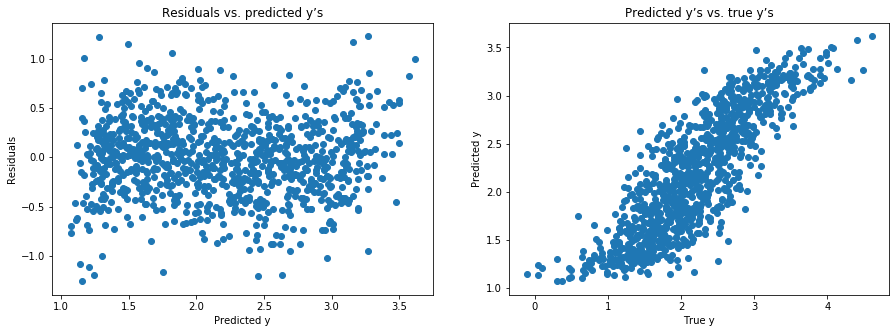

In [ ]:
fig,ax=plt.subplots(1,2,figsize = (15,5))

#plotting residuals vs. predicted y’s
ax[0].scatter(predictions,residuals)
ax[0].set_xlabel('Predicted y')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals vs. predicted y’s')

#plotting predicted y’s vs. true y's
ax[1].scatter(y,predictions)
ax[1].set_xlabel('True y')
ax[1].set_ylabel('Predicted y')
ax[1].set_title('Predicted y’s vs. true y’s')

plt.show()

#### - **Plot "Residuals vs. predicted y’s"**:

**Expected results:**

All points should be randomly located around zero with constant variance. Such a situation will confirm constant variance, non-existent dependency between predicted vs. residualsm linear relationship between dependent & independent variables. 

**Actual results:**

We see certain non-linear pattern in the plot with constant variance, which signals dependency between predicted vs. residuals. It could also mean that we have a non-linear relationship in our population. We probably shall also check normality of residuals with Q-Q plot.

#### - **Plot "Predicted y’s vs. true y’s"**:

**Expected results:**

Ideally all points shall be close to a regressed diagonal line (straight line at 45 degrees), which means that predicted values are close to the true values. 

**Actual results:**

We see that points are scattered in a non-linear fashion and we certainly can't say that all point are close to a regressed diagonal line.

### **5. If you wish to argue that education is insignificant and use the model with dummies than you have to check the simultaneous insignificance of all dummies which stem from the factor variable $ed$. Run a test for general linear hypothesis and conclude about the significance of $ed$. Write down the matrix and the vector needed in the hypothesis.**

We have $4$ dummies that stem from $ed$ at $11th,12th,13th,14th$ indexes. Let's construct our design matrix $R$ and vector $r$, needed in General Linear Hypothesis.

$R = \begin{pmatrix}0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\end{pmatrix}$

$r = (0,0,0,0)^T$

Our Hypotheses for the test are:

$H_0 = \beta_{11}=\beta_{12}=\beta_{13}=\beta_{14}=0$;

$H_1 \not= 0$ for at least one $\beta$.

Let's run a test for general linear hypothesis and conclude about the significance of $ed$, choosing our $\alpha = 0.05$. Note that in statsmodels software we only need to write design matrix $R$, as vector $r$ is computed automatically.

In [ ]:
R = np.array(([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
              ))

print(result.f_test(R))

<F test: F=array([[3.25471393]]), p=0.011539648129844732, df_denom=984, df_num=4>


**Conclusion:**

We see that p-value is $0.011$. Given that $\alpha=0.05$, it means that p-value$<\alpha$ and we can reject null hypothesis that $ed$ variable is insignificant.

### **6. Provide an economic interpretation for the parameters of $address$, $ed$, and $retire$. Neglect the possible insignificance and keep in mind possible transformations of the variables.**

We have not transformed our independent variables (we only log-transformed dependent $longmon$). 

- **address**:

In [ ]:
print("address coefficient:", result.params.address)

address coefficient: 0.0037868594079006335


Let's exponentiate $address$, subtract 1 and multiply by 100:

In [ ]:
100*(np.exp(result.params.address)-1)

0.3794038619349127

Hence, 1 unit increase in number of years, lived at certain address, will result in ~$0.4$% increase in long-distance calls, that seems reasonable to expect from customer, that becomes more habituated to the place of living. 

- **retire**

In [ ]:
print("retire coefficient:", result.params.retire)

retire coefficient: 0.19834593512981574


In [ ]:
print('By being retired client increases percent of his long-distance calls by',100*(np.exp(result.params.retire)-1),'%.')

By being retired client increases percent of his long-distance calls by 21.938414868129506 %.


- **ed**

Let's look at exponentiated parameters for $ed$ dummy variables:

In [ ]:
100*(np.exp(result.params[11:15]).sort_values()-1)

ed_Did not complete high school   -12.445476
ed_Post-undergraduate degree       -9.646898
ed_Some college                    -4.003929
ed_High school degree              -3.345989
dtype: float64

We see that all those $ed$ variables presence decrease percentage of long-distance calls for the client. The most negative impact on long-distance calls is by having incompleted high school (12% decrease), which is generally reasonable. However on other $ed$ variables I wouldn't be so sure, why they decrease percent of $longmon$.

### **7. Compute the 95% confidence intervals for the parameters of $address$ and $income$ and provide its economic meaning. Relate the CIs to the tests of significance, i.e. how would you use these intervals to decide about the significance of the corresponding explanatory variables? The CIs are computed relying on the assumption, that the residuals follow normal distribution. Is this assumption fulfilled? Run an appropriate goodness-of-fit test.**

**95%-CI and p-value computation for parameters:**

We will compute confidence intervals with the help of Statsmodels. Statsmodels library computes 95% confidence intervals during regression according to the formula:

$[\hat{\beta_j}-t_{N-K-1;1-\alpha/2}\cdot \sqrt{\hat{Var(\hat{\beta_j})}}; 
\hat{\beta_j}+t_{N-K-1;1-\alpha/2}\cdot \sqrt{\hat{Var(\hat{\beta_j})}}]$

Let's write a wrapper function for statsmodels 95%-CI computation routine:

In [ ]:
def conf_beta(reg_result,var_name):
    return reg_result.conf_int().loc[var_name, :]

95%-CI of $address$ and $income$:

In [ ]:
lower_bound_addr, upper_bound_addr = conf_beta(result,'address')
print('95%-CI for beta-parameter of "address":[{};{}]'.format(lower_bound_addr, upper_bound_addr))
print('')
lower_bound_inc, upper_bound_inc = conf_beta(result,'income')
print('95%-CI for beta-parameter of "income":[{};{}]'.format(lower_bound_inc, upper_bound_inc))

95%-CI for beta-parameter of "address":[0.00037762329450355143;0.0071960955212977155]

95%-CI for beta-parameter of "income":[-0.0003761327489784249;0.00020592863137949152]


Let's check p-values for beta-parameters of "address" and "income":

In [ ]:
p_value_addr = result.pvalues['address']
print('p-value for address beta-coefficient:',p_value_addr)
print('')
p_value_inc = result.pvalues['income']
print('p-value for income beta-coefficient:',p_value_inc)

p-value for address beta-coefficient: 0.029513197167586616

p-value for income beta-coefficient: 0.5662134072085576


**Conclusion on significance of beta-parameters:** 

We can say from 95% confidence interval of $address$ beta-coefficient that its true value of beta-coefficient with 95% probability lies in the interval that doesn't include zero, testifying in favour of $address$ coefficient significance. P-value confirms this statement. Thus, we can reject null hypothesis about $address$ insignificance.

On the contrary, p-value for $income$ beta-parameter doesn't allow us to reject the null hypothesis that $\beta=0$ for $income$. Simultaneously, we see that 95%-CI for beta-coef of $income$ includes 0, supporting previous sentence statement.

**Economic meaning:**

For economic meaning for 95%-CI of $address$ and $income$ beta-parameter let's exponentiate such parameters, because in our model we have log-transformed y-variable.

$address$ CI intepretation after exponentiation:

In [ ]:
lower_exp = np.exp(lower_bound_addr)
upper_exp = np.exp(upper_bound_addr)
print('Exponentiated 95%-CI for address beta-coefficient:[{},{}]'.format(lower_exp,upper_exp))

Exponentiated 95%-CI for address beta-coefficient:[1.0003776946031555,1.007222049635417]


From above exponentiated CI we can conclude that if there is one year (unit) increase in living at some place, it will result in long-distance calls increase by percentage in between [$0.03$%,$0.7$%] interval.

$income$ CI intepretation after exponentiation:

In [ ]:
lower_exp = np.exp(lower_bound_inc)
upper_exp = np.exp(upper_bound_inc)
print('Exponentiated 95%-CI for income beta-coefficient:[{},{}]'.format(lower_exp,upper_exp))

Exponentiated 95%-CI for income beta-coefficient:[0.9996239379800759,1.0002059498361355]


Here we have contradictory result, which directly stems from above-established insignificance of beta-coefficient for this variable, as from above result it seems like if there is one unit increase in income, it can result in long-distance calls both decrease and increase.

**Checking normality of residuals:**

Firstly, let's plot residuals distribution to get a feel of what's going on:

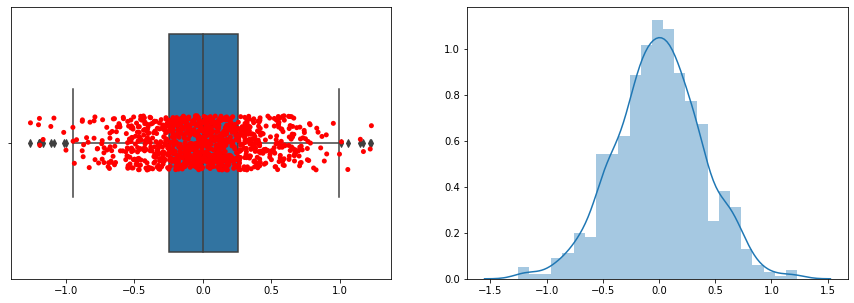

In [ ]:
res = result.resid
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(res,ax=axes[0])
sns.stripplot(res, color="red", ax=axes[0])
sns.distplot(res, ax=axes[1])
plt.show()

Seems like residuals are approxomately normal with zero mean, but having a lot of outliers (fatter tails). Let's do now a goodness-of-fit test, using Shapiro-Wilk and Kolgomorov-Smirnov tests. The former one is considered in research to have a relatively strong power.
For both tests, their null hypothesis is that underlying distribution is normal. 

Shapiro-Wilk test:

In [ ]:
print('Shapiro-Wilk test for residuals.')
stat, p = stats.shapiro(res)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk test for residuals.
Statistics=0.998, p=0.310
Sample looks Gaussian (fail to reject H0)


Kolgomorov-Smirnov test:

In [ ]:
print('Kolmogorov-Smirnov test for residuals.')
stat, p = stats.kstest(res/res.std(), 'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Kolmogorov-Smirnov test for residuals.
Statistics=0.019, p=0.859
Sample looks Gaussian (fail to reject H0)


**Conclusion:** residuals approximately follow normal distribution. 

### **8. Many of the variable appear insignificant and we should find the smallest model, which still has a good explanatory power. Choose this model using stepwise model selection (either based on the tests for $R^2$ or using $AIC/BIC$). Pick up the last step of the model selection procedure and explain in details how the method/approach works (or is implemented in your software). Work with this model in all the remaining steps.**

We will perform stepwise selection based on $AIC$ method. 

$AIC$ formula is the next:

$\ln(\hat{\sigma^{2}}) + \frac{2K}{N}$,

where

$\hat{\sigma^{2}}$ - sample variance of prediction error;

K - number of dependent variables;

N - number of samples.

As we see, $AIC$ penalizes models with bigger prediction error and more independent variables via multiplying result by 2. Thus, the lesser is $AIC$ - the better is the model. 

Let's create our stepwise selection algorithm (a.k.a stepwise regression) with AIC criterion:


In [ ]:
#creating our independent and dependent variables
X = df.drop(['longmon_log','longmon'],axis=1).copy()
y = df['longmon_log'].copy()

#all names of our indep.vars
ind_var_names = X.columns.tolist()

#function
def stepwise_selection(X, y, regressors_left):
    #creating an empty list for selected regressors
    regressors_selected = []
    #creating empty list for scores
    scores_selected = []
    #creating default starting best score as np.inf as its bigger than any future scores and suitable for starting loop
    best_score = np.inf 
    #assigning current score to starting best score
    score = best_score
    #looping until either all independent variables are used in all possible combinations or when further fit give no
    #improvement in AIC 
    while regressors_left != [] and score==best_score:
        regressor_score = []
        for regressor in regressors_left:
            X_selected = X.loc[:, regressors_selected+[regressor]]
            X_selected_ = sm.add_constant(X_selected)
            model_res = sm.OLS(y,X_selected_).fit()
            s = model_res.aic
            regressor_score.append(s)
        i = np.argmin(regressor_score) 
        score = regressor_score[i]
        if (score < best_score):
            best_score = score 
            regressors_selected.append(regressors_left[i])
            scores_selected.append(score)
            del regressors_left[i]
    last_var = regressors_left[i]
    last_score = score
    print('Stepwise selection with AIC picked {} independent variables:\n{}'.format(len(regressors_selected), regressors_selected))
    return regressors_selected,last_var,scores_selected,last_score

regressors_selected,last_reg,scores_selected,last_score = stepwise_selection(X, y, ind_var_names)

Stepwise selection with AIC picked 6 independent variables:
['tenure', 'retire', 'ed_Did not complete high school', 'marital', 'address', 'ed_Post-undergraduate degree']


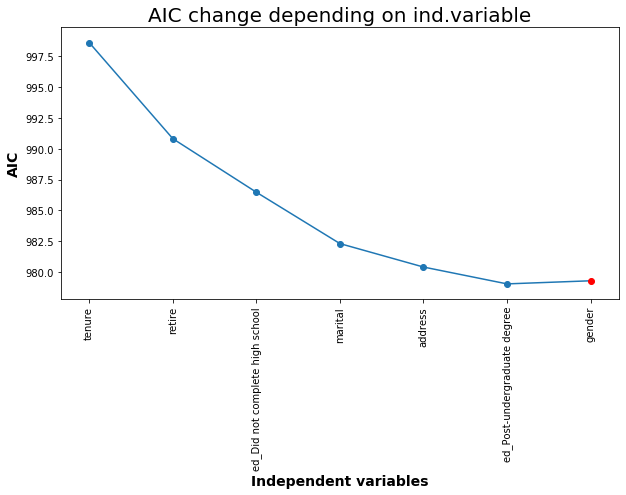

In [ ]:
x = regressors_selected+[last_reg]
y = scores_selected+[last_score]
plt.figure(figsize=(10,5))
plt.plot(x, y)
plt.scatter(x[:-1], scores_selected)
plt.scatter(x[-1], last_score, color='r', zorder=10)
plt.xticks(rotation='vertical')
plt.xlabel('Independent variables',fontsize=14,fontweight='bold')
plt.ylabel('AIC',fontsize=14,fontweight='bold')
plt.title('AIC change depending on ind.variable',fontsize=20)
plt.show()

**Algorithm of stepwise model selection for AIC works in the next way:**

1) It starts from fitting a separate model with each independent variable solely, counting AIC for every model. Then it chooses independent variable with the lowest AIC value;

2) Algorithm then takes chosen independent variable and fits a separate model (using chosen dependent variable) for each independent variable that is left; It chooses second independent variable which (together with first chosen ind. variable) that gives best AIC if such AIC is better than fitting the model with just first var.

3)  Algorithm continuos in the same manner with rest of left ind.variables until AIC is not improving from adding new ind.variable to model.

We will further use this model:

In [ ]:
X_sel = X.loc[:, regressors_selected].copy()
X_sel_ = sm.add_constant(X_sel)
y = df['longmon_log'].copy()
new_model = sm.OLS(y,X_sel_)
result = new_model.fit()

### **9. Sometimes data contains outliers which induces bias in the parameter estimates. Check for outliers using Cook’s distance and leverage. Have a closer look at the observation with the highest leverage (regardless if it is classified as an outlier or not). What makes this observation so outstanding (you may have a look at Box-plots for interval scaled variables or at the frequencies for binary/ordinal variables?**

One of the most common ways to detect response variable outliers is to plot Cook's distances per observation and use some rule of thumb for threshold value (but it should not be used as a law). 

Let's Cook's distance  values from OLS statsmodels function:

In [ ]:
influence = result.get_influence()
#c is the distance and p is p-value
(c, _) = influence.cooks_distance

Let's determine threshold for Cook's distance using well-known rule of thumb $\frac{4}{n}$.

In [ ]:
threshold = 4/(X.shape[0])
print(threshold)

0.004


Finding response variable outliers using above defined threshold:

In [ ]:
outliers = pd.DataFrame(c,columns=['cook_dist'])
outliers = outliers.loc[outliers['cook_dist'] > threshold]

Plotting Cook's distance per observation with threshold (red line):

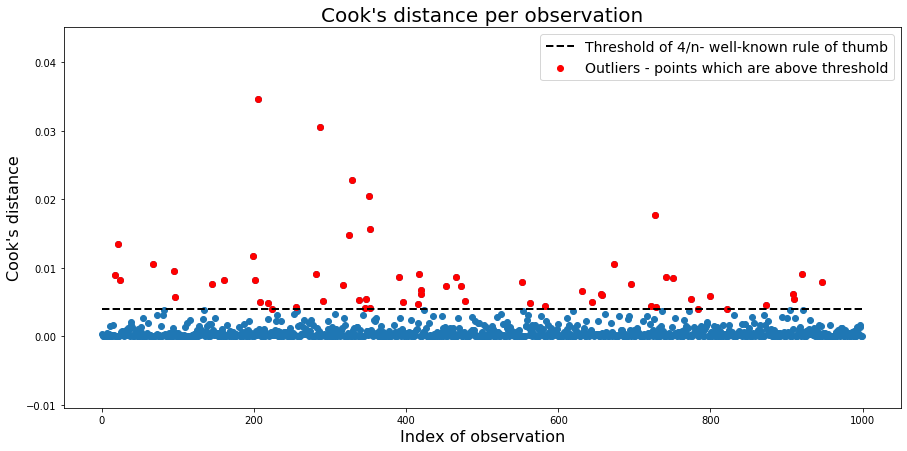

There are 60 response variable outliers


In [ ]:
plt.figure(figsize=(15,7))
#plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.scatter(np.arange(len(c)), c, )
plt.hlines(y=threshold, xmin=0, xmax=len(X), colors='black', linestyles='--', lw=2)
plt.scatter(outliers.index.tolist(), outliers['cook_dist'],color='red')
plt.ylabel("Cook's distance",fontsize=16)
plt.xlabel('Index of observation',fontsize=16)
plt.legend(["_","Threshold of 4/n- well-known rule of thumb","Outliers - points which are above threshold"],fontsize=14)
plt.title("Cook's distance per observation",fontsize=20)
plt.show()
print('There are {} response variable outliers'.format(len(outliers)))

Let's plot our leverage per observation plot. In general, high leverage value doesn't mean that observation is an outlier. Let's paint outliers with other color and see what highest leverage points are also classified as outliers:

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence

leverage = OLSInfluence(result).summary_frame()[['hat_diag']]

In [ ]:
max_lev = leverage.sort_values(by=['hat_diag'],ascending=False).iloc[0]

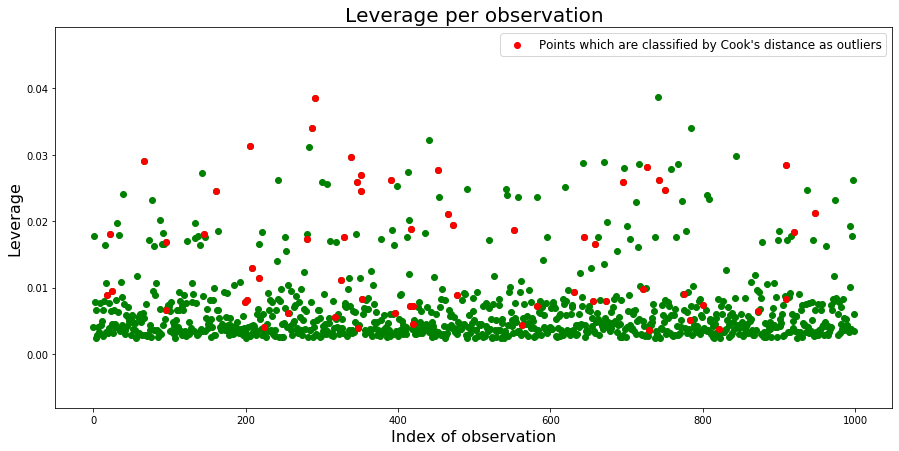

Index of highest leverage point is 742


In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(np.arange(len(leverage)), leverage['hat_diag'], c='green')
plt.scatter(outliers.index.tolist(), leverage.iloc[outliers.index.tolist()],color='red')
plt.ylabel("Leverage",fontsize=16)
plt.xlabel('Index of observation',fontsize=16)
plt.legend(['_',"Points which are classified by Cook's distance as outliers"],fontsize=12)
plt.title('Leverage per observation',fontsize=20)
plt.show()
print('Index of highest leverage point is {}'.format(leverage['hat_diag'].sort_values().tail(1).index.values[0]))

**Conclusion:**

We see that our highest leverage point is indeed classified by Cook's distance metric as an outlier. In general, a lot of outliers are also among the highest leverage points. 

Let's look at our highest leverage point more closely by plotting Box-plot distribution firstly for each interval-scaled variable of our model and plotting a dashed line for such variable value of highest leverage point. This way we can see visually which independent variable leads to such observation being the highest leverage:

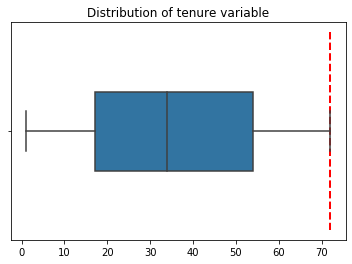

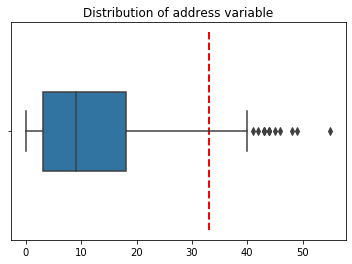

In [ ]:
interval_vars = ['tenure','address']
for var in interval_vars:  
    sns.boxplot(X_sel[var].values)
    plt.vlines(X_sel.iloc[max_lev.name][var], ymin=-1, ymax=1, linestyle='--',colors='red', lw=2)
    plt.title('Distribution of {} variable'.format(var))
    plt.show()

**Conclusion:**

We can conclude that for both interval variables our highest leverage observation takes extreme values. It means that both $tenure$ and $address$ possibly contributes to making our observation so outstanding.


Let's see frequencies for our binaries:

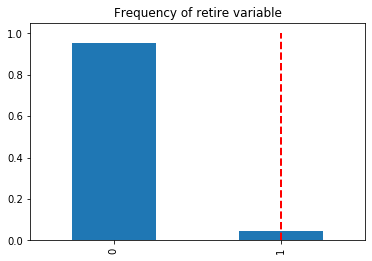

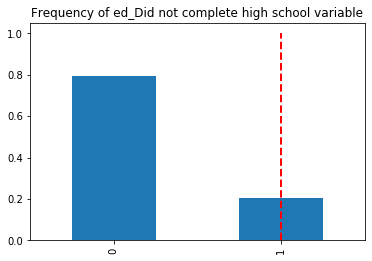

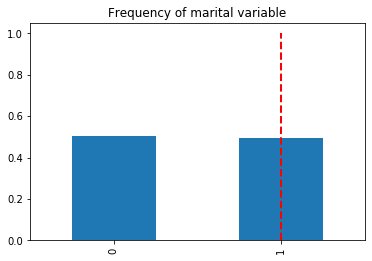

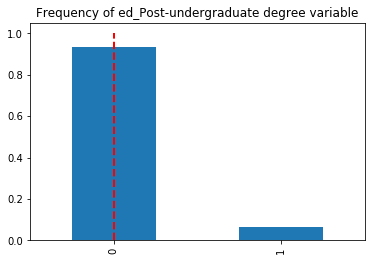

In [ ]:
binary_vars = ['retire','ed_Did not complete high school','marital','ed_Post-undergraduate degree']
for var in binary_vars:  
    X_sel[var].value_counts(normalize=True).plot(kind='bar')
    plt.vlines(X_sel.iloc[max_lev.name][var], ymin=0, ymax=1, linestyle='--',colors='red', lw=2)
    plt.title('Frequency of {} variable'.format(var))
    plt.show()

**Conclusion:**

Among our binary variables, our observation only in case of $retire$ takes a rare value. Thus, $retire$ can also contribute to making the observation so high in leverage.  

### **10. Frequently data is missing. Pick up 5 rows in the data set and delete the value for address. Implement at least two approaches to fill in these values. Write down the corresponding formulas/model and give motivation for your approach. If you use standard routines then check how exactly the data imputation is implemented. How would you proceed if the value of the binary variable $retire$ is missing? Implementation is not required.**

Let's delete value of $address$ at 5 random rows:

In [ ]:
X_copy = X_sel.copy()
rows_idx = [np.random.randint(1,len(X_copy)+1) for i in range(5)]
X_copy.loc[(X_copy.index.isin(rows_idx)),'address'] = np.nan
print(X_copy.isnull().any())

tenure                             False
retire                             False
ed_Did not complete high school    False
marital                            False
address                             True
ed_Post-undergraduate degree       False
dtype: bool


We have missing data completely at random. 

In our case we don't have a lot of data, so dropping rows can lead to us losing significant information. 



- **mean imputation**

We will do mean imputation, as this is the simplest method and also because sample mean variable is not biased. However, the method contains few drawbacks.

In [ ]:
X_copy.loc[(X_copy.index.isin(rows_idx)),'address'] = np.nan
X_copy['address'].fillna(X_copy['address'].mean(),inplace=True)

It works just simple:

$missing$_$value_{address}$ = $\mathbb{E}[address]$.

- **one-hot imputation**:

As in real life we don't know why data is missing, one of the most popular methods for imputation is one-hot encoding by creating a dummy variable. It works by creating a dummy variable that indicates whether a data point is missing, then substituting any arbitrary value (like $0$) for the missing data in the original variable.

In [ ]:
X_copy.loc[(X_copy.index.isin(rows_idx)),'address'] = np.nan
X_copy['NaN_address'] = 0
X_copy['NaN_address'] = X_copy.address.map({np.nan:1})

In case of missing $retire$, given that it's a binary variable, it would be appropriate to sample values from frequency distribution and fill NaNs by them. 

### **11. We consider now the model you have worked with so far and the model with original $y$ if you applied some transformation OR the model with $log(y)$ if you have not transformed $y$. Run an appropriate test to decide which of the models is superior. Explain, the idea of the test and why you cannot make a similar decision using $AIC/BIC$, etc.**

1) In our case we have a log-linear model (transformed dependent variable).

2) In this case an appropriate way of checking whether log-linear model is better than simple linear is: 

- to fit a new model, which includes prediction both from linear and log-linear models for the formula: $y_i = \beta x_i + \delta_{lin}(\ln \hat{y_i}-\hat{\ln y_i})$, 

where

$\hat{y_i}$ - predictions from linear model;

$\hat{\ln y_i}$ - predictions from log-linear model;
- check from regression results whether $H_0:\delta_{lin}=0$ is not rejected;
- if it's rejected - log-linear model provides additional valuable information in predicting $y$, otherwise linear model is superior.

3) The idea of the test is to check whether difference between log-transformed prediction from linear model and prediction from log-linear model ($\ln \hat{y_i}-\hat{\ln y_i}$) have any influence on prediction.

4) The reason why we can't make similar decision using $AIC/BIC$ or $R^2_{adj}$ is that in formulas for both cases we are using fitted model residuals, which make impossible comparison of such metrics across models with different natures of residuals, where in one case residuals come from log-transformed $y$ and in another from original $y$.

Implementation of above-test:

- Same model with original $y$ (fit and prediction):

In [ ]:
X_sel = X.loc[:, regressors_selected].copy()
X_sel_ = sm.add_constant(X_sel)
y_orig = df['longmon'].copy()
linear_model = sm.OLS(y_orig,X_sel_)
result_linear = linear_model.fit()

($\ln \hat{y_i}-\hat{\ln y_i}$):

In [ ]:
diff = np.log(result_linear.predict(X_sel_)) - result.predict(X_sel_)

Adding new variable to our X data:

In [ ]:
X_sel_['diff'] = diff

Fitting:

In [ ]:
idx=X_sel_[np.isnan(X_sel_['diff'])].index.tolist()
X_sel_=X_sel_.drop(idx,axis=0)
y_orig=y_orig.drop(idx,axis=0)
check_model = sm.OLS(y_orig,X_sel_)
check_result = check_model.fit()
check_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                longmon   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     182.4
Date:                Sun, 09 Feb 2020   Prob (F-statistic):          2.54e-172
Time:                        03:30:02   Log-Likelihood:                -3279.2
No. Observations:                 982   AIC:                             6574.
Df Residuals:                     974   BIC:                             6613.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.9854      0.535     -5.579      0.000      -4.036      -1.935
tenure                              0.3513      0.013     26.603      0.000       0.325       0.377
retire                              7.4869      1.078      6.945      0.000       5.371       9.602
ed_Did not complete high school    -1.5206      0.559     -2.718      0.007      -2.619      -0.423
marital                             1.5132      0.450      3.365      0.001       0.631       2.396
address                             0.1160      0.026      4.415      0.000       0.064       0.168
ed_Post-undergraduate degree       -2.4481      0.907     -2.700      0.007      -4.227      -0.669
diff                               -3.7790      0.457     -8.263      0.000      -4.677      -2.882
==============================================================================
Omnibus:                      715.280   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19925.094
Skew:                           2.990   Prob(JB):                         0.00
Kurtosis:                      24.242   Cond. No.                         216.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusion:**

We see that we can reject null hypothesis and log-linear model is significant as p-value of diff $\delta_{lin}$ is < 0.05 for ($\ln \hat{y_i}-\hat{\ln y_i}$).

### **12. We compare the predictive ability of the estimated regression. Consider the model you worked so far and the original model with the same $y$ but without transformation and selection of features. Compare the two models using $leave-one-out-CV$ and $5-fold-CV$. Explain the idea of this technique with formulas and draw a conclusion about the predictive ability of the models.**

General formula for K-fold cross-validation is the next:

$
CV(\hat f) = \frac{1}{N}\sum_{i=1}^N L(y_i,\hat{f}^{-K(i)}(x_i))
$

,where

$\hat{f}^{-K(i)}$ - fitted function. computed with the k-$th$ part of the data removed, to which we allocate observations, indexed by $i$;

$\hat{f}^{-K(i)}(x_i)$ - prediction value;

$y_i$ - true value; 

$L$ - loss function;

$N$ - number of data points/

**K-fold Cross-validation procedure** works in the following manner:

- In the loop of K times we fit our data on $K-1$ parts of the data and test fitted model with some mean loss function. 

- Each time in the fitting we use new K part for the testing. 

- After accumulating test results from each of the $K$ parts we often find average test result from $K$ fits, so that we can compare one algorithm to another in its performance.

**Leave-one-out Cross-validation** is just K-fold procedure at its extreme, where $K=N$ and fitted model is tested on each data point sequentially after fitting to all other data points. 







Let's perform K-fold CV for our models:

- **New model**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
X_sel = X.loc[:, regressors_selected].copy()
linreg = LinearRegression()
scores = cross_validate(linreg, X_sel, y, cv=5,
                         scoring=('neg_mean_squared_error','r2'),
                         )
print('New model MSE without feature selection:',-np.mean(scores['test_neg_mean_squared_error']))
print('New model R^2 without feature selection:',np.mean(scores['test_r2']))

New model MSE without feature selection: 0.15645456339174205
New model R^2 without feature selection: 0.7085576342969189


- **Old model**

In [ ]:
linreg = LinearRegression()
scores = cross_validate(linreg, X, y, cv=5,
                         scoring=('neg_mean_squared_error','r2'),
                         )
print('Original model MSE without feature selection:',-np.mean(scores['test_neg_mean_squared_error']))
print('Original model R^2 without feature selection:',np.mean(scores['test_r2']))

Original model MSE without feature selection: 0.15809864301782392
Original model MSE without feature selection: 0.7054711431617087


No differences in terms of $MSE$ or $R^2$ for $K-fold$.

Leave-one-out:

- **New model:**

In [ ]:
linreg = LinearRegression()
scores = cross_validate(linreg, X_sel, y, cv=len(X_sel),
                         scoring=('neg_mean_squared_error'),
                         )
print('New model MSE without feature selection:',-np.mean(scores['test_score']))

New model MSE without feature selection: 0.15600960358909652


- **Old model:**

In [ ]:
linreg = LinearRegression()
scores = cross_validate(linreg, X, y, cv=len(X),
                         scoring=('neg_mean_squared_error'),
                         )
print('Original model MSE without feature selection:',-np.mean(scores['test_score']))

Original model MSE without feature selection: 0.15750107053924814


**Conclusion:**

There is no difference in terms of cross-validation performance between orifinal and new models.

## **Problem 5: Further issues**

#### **Suppose that we create a new variable $y_t^{∗} = y_t +10$ and run the same linear regression using $y_t^{∗}$ instead of $y_t$ as a regressand.**

#### **1. How are $R^2$ and the estimate of the constant term related in the two regressions? What if we use $y_t^{∗} = y_t − 10$ instead?**

We know that addition of a constant to random variable just shifts the mean by such constant. In geometrical sense this would look like shifting every point 10 points up/down and we will have the same line with the same slope just ten points higher/lower. Consequently, it means that $y$-axis intercept will be 10 points higher/lower and $R^2$ (as a measure of explained variance) will stay the same.

Formally,

$y_t = \beta_0 + \sum_{1}^{k}\beta_{k}x_{tk}+u_t$;

$y_t^{*} = (\beta_0 + \sum_{1}^{k}\beta_{k}x_{tk}+u_t)+10
\rightarrow u_t^{*}=u_t.
$



$\hat{y_t} = \hat\beta_0 + \sum_{1}^{k}\hat\beta_{k}x_{tk} \rightarrow$

$\rightarrow \hat{y_t^{*}} = (\hat\beta_0 + \sum_{1}^{k}\hat\beta_{k}x_{tk})+10 \rightarrow$ 

$\rightarrow \hat\beta_0^{*}=\hat\beta_0+10$

As $u_t^{*}=u_t$ and $s_{y^{*}}^{2}=\frac{\sum_{1}^{N}(y_t^{*}-\bar{y^{*}})^2}{N-1}$=$\frac{\sum_{1}^{N}((y_t+10)-(\bar{y}+10))^2}{N-1}=
\frac{\sum_{1}^{N}(y_t-\bar{y})^2}{N-1}=s_{y}^{2} \rightarrow
$

$\rightarrow R^{*2}=1 - \frac{\sum_{1}^{N}u_t^{*2}}{s_{y^{*}}^{2}}=1 - \frac{\sum_{1}^{N}u_t^{2}}{s_{y}^{2}}=R^{2}$ .





#### **2. What if we do the same with one or all of the regressors?** 

If we do that with regressors, we will geometrically only notice shift across respective independent variable axes. 

For $R^2$ it means that it stays unchanged.

In case of our new constant (intercept) $\beta_0^{*}$ we have the following in case of one regressor:

$x_{t1}^{*} = x_{t1} + \alpha
\rightarrow
$

$
\rightarrow
\hat {y_t} = \hat {\beta_0} + \hat {\beta_1} x_{t1} + \cdots + \hat {\beta_K x_{tK}} = 
$

$
=\hat {\beta_0} + \hat {\beta_1 (x_{t1}} + \alpha_1 - \alpha_1) + \cdots + \hat {\beta_K x_{tK}}=
$

$ = \hat {\beta_0} + \hat {\beta_1} x^*_{t1} - \hat \beta_1\alpha_1 + \cdots + \hat \beta_K x_{tK} =
$

$
(\hat \beta_0 - \hat \beta_1\alpha_1) + \hat \beta_1 x^*_{t1} + \cdots + \hat \beta_K x_{tK} = 
$

$
\hat \beta^*_0 + \hat \beta^*_1 x^*_{t1} + \cdots + \hat \beta^*_K x_{tK}
\rightarrow
$

$
\rightarrow
\hat \beta^*_0  = \hat \beta_0 - \hat \beta_1\alpha_1
$

It means that in general case it holds that
$
\hat \beta^*_0 = \hat \beta_0 - \sum_{k=1}^K \hat \beta_k \alpha_k
$

#### **3. Consider a demeaned regression, i.e. center the regressors and the regressand to have zero mean. How does it influence the estimates?**

In case of constant such operation just accumulates all above effects:

- Shifting regressors results for $\hat \beta_0$ in
$
 - \sum_{k=1}^K \hat \beta_k \alpha_k
$

- Shifting regressand results for $\hat \beta_0$ in $-\bar y$.

Consequently, we have:

$\hat \beta_0^*=\hat \beta_0 -\bar y - \sum_{k=1}^K \hat \beta_k \alpha_k$.

Naturally, $R^2$ remains unchanged for those cases.